In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from datasets import load_dataset
import matplotlib.pyplot as plt
%matplotlib inline


torch.manual_seed(12046)

In [2]:
learning_rate = 1e-3
eval_iters = 10
batch_size=5000
sequence_len=64
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
raw_datasets = load_dataset("code_search_net", "python")
datasets = raw_datasets['train'].filter(lambda x: 'apache/spark' in x['repository_name'])

In [4]:
class char_tokenizer:

    def __init__(self, data):
        # 数据中出现的所有字符构成字典
        chars = sorted(list(set(''.join(data))))
        # 预留一个位置给结尾的特殊字符
        self.char2ind = {s : i + 1 for i, s in enumerate(chars)}
        self.char2ind['<|e|>'] = 0
        self.ind2char = {i : s for s, i in self.char2ind.items()}

    def encode(self, text):
        return [self.char2ind[c] for c in text]

    def decode(self, enc):
        if isinstance(enc, int):
            return self.ind2char[enc]
        return [self.ind2char[i] for i in enc]

tok = char_tokenizer(datasets['whole_func_string'])
len(tok.char2ind)

98

In [5]:
class CharLSTM(nn.Module):

    def __init__(self, vs):
        super().__init__()
        self.emb_size = 256
        self.hidden_size = 128
        self.embedding = nn.Embedding(vs, self.emb_size)
        self.lstm1 = nn.LSTM(self.emb_size, self.hidden_size, 1,
                            batch_first=True, dropout=0.4)
        self.norm1 = nn.LayerNorm(self.hidden_size)
        self.lstm2 = nn.LSTM(self.emb_size, self.hidden_size, 1,
                            batch_first=True, dropout=0.4)
        self.norm2 = nn.LayerNorm(self.hidden_size)
        self.lstm3 = nn.LSTM(self.emb_size, self.hidden_size, 1,
                            batch_first=True, dropout=0.4)
        self.norm3 = nn.LayerNorm(self.hidden_size)
        self.h2o = nn.Linear(self.hidden_size, vs)

    def forward(self, x):
        # x: (B, T)
        emb = self.embedding(x)      # (B, T, C)
        h = self.norm1(self.lstm1(emb)[0])       # (B, T, H)
        h = self.norm2(self.lstm2(emb)[0])       # (B, T, H)
        h = self.norm3(self.lstm3(emb)[0])       # (B, T, H)
        output = self.h2o(h)         # (B, T, V)
        return output

model = CharLSTM(len(tok.char2ind)).to(device)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.4 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [6]:
model

CharLSTM(
  (embedding): Embedding(98, 256)
  (lstm1): LSTM(256, 128, batch_first=True, dropout=0.4)
  (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (lstm2): LSTM(256, 128, batch_first=True, dropout=0.4)
  (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (lstm3): LSTM(256, 128, batch_first=True, dropout=0.4)
  (norm3): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (h2o): Linear(in_features=128, out_features=98, bias=True)
)

In [7]:
@torch.no_grad()
def generate_batch(model, idx, max_new_tokens=300):
    for _ in range(max_new_tokens):
        # 限制背景长度，使之与模型训练时的状况更相符
        # 当然也可以不限制
        context = idx[:, -sequence_len:]
        logits = model(context)
        logits = logits[:, -1, :]
        probs = F.softmax(logits, dim=-1)
        ix = torch.multinomial(probs, num_samples=1)
        idx = torch.cat((idx, ix), dim=1)
        if ix.item() == 0:
            break
    return idx.tolist()[0]

In [8]:
re = generate_batch(model, torch.tensor(tok.encode('def'), device=device).unsqueeze(0))
print(''.join(tok.decode(re)))

def$O(F/of("YA{BoE G|uw=3:1'L$?Q9)N[-KQ=CKfAM:iKcaR%+Q3j<sA!uWö$?09x!q/T3"yMm54a)'B~5\WP&B?({r{cNtMhSD*<|e|>


In [9]:
def process(data, sequence_len=sequence_len):
    text = data['whole_func_string']
    inputs, labels = [], []
    for i in text:
        enc = tok.encode(i)
        enc += [0]
        for i in range(len(enc) - sequence_len):
            inputs.append(enc[i: i + sequence_len])
            labels.append(enc[i + 1: i + 1 + sequence_len])
    return {'inputs': inputs, 'labels': labels}

tokenized = datasets.map(process, batched=True, remove_columns=datasets.column_names)
tokenized.set_format(type='torch', device=device)
tokenized

Dataset({
    features: ['inputs', 'labels'],
    num_rows: 668546
})

In [10]:
from torch.utils.data import DataLoader

# 构建数据读取器
train_loader = DataLoader(tokenized, batch_size=batch_size, shuffle=True)
# 获取一个批量的数据
next(iter(train_loader))

{'inputs': tensor([[ 2,  2,  2,  ...,  1,  2,  2],
         [71, 85, 86,  ..., 78, 75, 85],
         [78, 85, 63,  ..., 78, 85,  2],
         ...,
         [73, 80, 81,  ..., 85, 87, 68],
         [91,  2, 67,  ..., 70, 71, 84],
         [71, 78, 75,  ..., 78, 75, 72]], device='cuda:0'),
 'labels': tensor([[ 2,  2,  2,  ...,  2,  2,  2],
         [85, 86, 84,  ..., 75, 85, 86],
         [85, 63,  1,  ..., 85,  2, 31],
         ...,
         [80, 81, 84,  ..., 87, 68, 85],
         [ 2, 67, 82,  ..., 71, 84,  2],
         [78, 75, 72,  ..., 75, 72,  2]], device='cuda:0')}

In [11]:
def estimate_loss(model):
    re = {}
    # 将模型切换至评估模式
    model.eval()
    re['train'] = _loss(model, train_loader)
    # 将模型切换至训练模式
    model.train()
    return re

@torch.no_grad()
def _loss(model, data_loader):
    """
    计算模型在不同数据集下面的评估指标
    """
    loss = []
    data_iter = iter(data_loader)
    for k in range(eval_iters):
        data = next(data_iter, None)
        if data is None:
            break
        inputs, labels = data['inputs'], data['labels']
        logits = model(inputs)
        logits = logits.transpose(-2, -1)
        loss.append(F.cross_entropy(logits, labels))
    return torch.tensor(loss).mean().item()

In [12]:
def train_lstm(model, optimizer, data_loader, epochs=10):
    lossi = []
    for epoch in range(epochs):
        for i, data in enumerate(data_loader, 0):
            inputs, labels = data['inputs'], data['labels']
            optimizer.zero_grad()
            logits = model(inputs)
            logits = logits.transpose(-2, -1)
            loss = F.cross_entropy(logits, labels)
            lossi.append(loss.item())
            loss.backward()
            optimizer.step()
        # 评估模型，并输出结果
        stats = estimate_loss(model)
        print(f'epoch {epoch:>2}: train loss {stats["train"]:.4f}')
    return lossi

In [13]:
l = train_lstm(model, optim.Adam(model.parameters(), lr=learning_rate), train_loader)

epoch  0: train loss 1.7597
epoch  1: train loss 1.4172
epoch  2: train loss 1.2542
epoch  3: train loss 1.1489
epoch  4: train loss 1.0838
epoch  5: train loss 1.0351
epoch  6: train loss 0.9965
epoch  7: train loss 0.9658
epoch  8: train loss 0.9409
epoch  9: train loss 0.9180


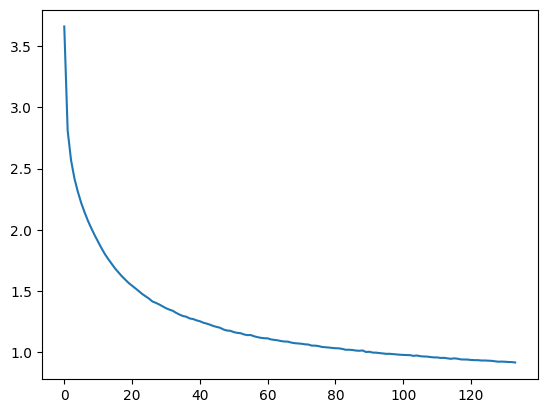

In [14]:
plt.plot(torch.tensor(l).view(-1, 10).mean(1).numpy())

In [15]:
re = generate_batch(model, torch.tensor(tok.encode('def'), device=device).unsqueeze(0))
print(''.join(tok.decode(re)))

def1 integer."""Tast combineQuor_array(self.intercept_suctTyps(e))
        c += new_argspect(from_arroint__name)
        else:
        procolFunc=portable)
        sparkStmAsTime = _mode_jira or open(distinct):
            re/genext(most) of __'(1\099728510')]
    """
    sape(pyspark.ml.issmalledingKM
